In [2]:
import pytraj as pt 
import numpy as np 
from BetaPose import representations
from BetaPose.representations import * 

top = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_END.pdb"; 
traj = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_traj.nc";
traj = pt.load(traj, top=top, mask=":1-151,:LIG", stride=100)
traj

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


pytraj.Trajectory, 11 frames: 
Size: 0.000610 (GB)
<Topology: 2479 atoms, 152 residues, 2 mols, PBC with box type = cubic>
           

### Feature array 
#### Topological features: Feature 1-6, including the Atom number etc 
#### Geometric features: Feature 7-12, including the pseudo-lj etc


|||||||
|--|--|--|--|--|--|
|1|2|3|4|5|6|
|Atom number(DONE)|Carbon Number(DONE)|Donor number(DONE)|Acceptor number(DONE)|Positive charge(DONE)|Negative charge(DONE)|
|7|8|9|10|11|12|
|Pseudo LJ(DONE)|Pseudo Elec(DONE)|Surface Area(DONE)|Occupied Volume(DONE)|Mean radius(DONE)|Convex hull(DONE)|

#### Other feature: 
#### - Fast Point Feature Histograms(FPFH in open3d): Use for matching and registration. 

# Speed table 
|Index|Function|Speed (1e6 times)|Comment|
|--|--|--|--|
|x|fpfh_similarity|430|(33x600 matrix)|
|p1|Atom number|0.8|Very fast|
|p2|Carbon number|2675.18|Could be faster|
|p3|Donor number|7366/2|16 atoms, Largely depend on input structure (1417/2 for small ones)|
|p4|Acceptor number|7366/2|16 atoms, Largely depend on input structure (1417/2 for small ones)|
|p5|Positive charge|9122/2|16 atoms, Slightly depend on input structure (7457/2 for small ones)|
|p6|Negative charge|9122/2|16 atoms, Slightly depend on input structure (7457/2 for small ones)|
|p7|pseudo_lj|535|16 atoms, determined by atom number|
|p8|pseudo_elec|375.38|15 atoms, determined by atom number|
|p9|Surface Area|20.78|relative short|
|p10|Occupied Volume|8830.38|relative long, difficult to reduce|
|p11|mean_radius|24.55|16 atoms|
|p12|hull_ratio|554.67|600 points|
|reg|doregistration|203919| 2300 points vs 2300 points|

In [30]:
def vectorizemolblock(traj, whichframe, segments, grid_center, grid_length, clear=True, msms=""): 
  """
  NOTE: voxel_down_sample might be a better solution to keep most feature during down-sampling
  >>> pcd_new = o3d.geometry.PointCloud( points=o3d.utility.Vector3dVector(finalobj.vertices))
  >>> pcd_new.normals = o3d.utility.Vector3dVector(mesh.vertex_normals)
  >>> finalobj_down = pcd_new.voxel_down_sample(0.8); 
  >>> finalobj_down.estimate_normals(ktree); 
  """

  for segi in utils.ordersegments(segments[whichframe])[:6]: 

      # Descriptor 9 and 10: Surface area and volume of the mesh
      try: 
        SA  = mesh.get_surface_area(); 
        VOL = mesh.get_volume(); 
        print(f"{datetime.datetime.now().time().__str__():15s}: {'Volume':15s} {VOL:10.3f} | {'Surface Area':15s} {SA:10.3f} |");
      except: 
        # If first attemp fails, try reducing the point density and reducing probe radius, and generate grids again
        traj2msms(msms, traj, whichframe, theidxi, out_prefix=file1.name, force=True, d=3, r=1.2); 
        mesh = msms2mesh(f"{file1.name}.vert", f"{file1.name}.face", filename=f"{file1.name}.ply"); 
        mesh = o3d.io.read_triangle_mesh(f"{file1.name}.ply"); 
        mesh.compute_vertex_normals(); 
        mesh.remove_degenerate_triangles(); 


      # Descriptor 11, 12: Mean radius and Convex hull ratio 
      pcd = mesh.sample_points_uniformly(self.FPFH_DOWN_SAMPLES); 
      hull, _ = pcd.compute_convex_hull(); 
      hull_ratio = len(hull.vertices)/self.FPFH_DOWN_SAMPLES; 
      mean_radius = np.linalg.norm(np.asarray(pcd.points) - pcd.get_center(), axis=1).mean()
      fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
      print(f"{datetime.datetime.now().time().__str__():15s}: {'Ratio convex':15s} {hull_ratio:10.3f} | {'Mean radius':15s} {mean_radius:10.3f} |"); 
      # print(f"{'INFO':15s}: The shape of the fpfh feature is {fpfh.data.shape}")
      fpfhs.append(fpfh.data)

    # Descriptor 3 and 4: Counter hydrogen bond donor and acceptors. 
    resmask = utils.getresmask(traj, utils.getmaskbyidx(traj, theidxi)); 
    coord_d, coord_a = chemtools.DACbytraj(traj, whichframe, resmask); 
    withinbox_d = utils.boxfilter(coord_d, grid_center, grid_length);
    withinbox_a = utils.boxfilter(coord_a, grid_center, grid_length);
    number_d = len(withinbox_d);
    number_a = len(withinbox_a);
    print(f"{datetime.datetime.now().time().__str__():15s}: {'HB Donor(s)':15s} {number_d:10d} | {'HB Acceptor(s)':15s} {number_a:10d} |");

    # Descriptor 5 and 6: Counter positive partial charge and negative partial charge.
    charges = chemtools.Chargebytraj(traj, whichframe, resmask); 
    withinbox = utils.boxfilter(np.array([i for i in charges.keys()]), grid_center, grid_length);
    charge_p = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]>0]);
    charge_n = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]<0]);
    print(f"{datetime.datetime.now().time().__str__():15s}: {'Positive charge':15s} {charge_p:10.3f} | {'Negative charge':15s} {charge_n:10.3f} |"); 

    framefeature[segcounter, :] = featurevector
    print(f"{datetime.datetime.now().time().__str__():15s}: Final vector:", np.array(featurevector).astype(float).round(3).tolist())
    mesh.paint_uniform_color(CMAP6[segcounter]); 
    if segcounter == 0: 
      finalobj = mesh; 
    else: 
      finalobj += mesh; 
    segcounter += 1
    
  # Translate the Center of the shape to the origin point; 
  finalobj.translate([0,0,0], relative=False); 
  # Down sample it and calculate the FPFH
  ktree = o3d.geometry.KDTreeSearchParamHybrid(radius=1.5, max_nn=20);
  finalobj_down = finalobj.sample_points_uniformly(fpfh_samples); 
  finalobj_down.estimate_normals(ktree); 
  finalobj_fpfh = o3d.pipelines.registration.compute_fpfh_feature(finalobj_down, ktree); 
  return framefeature.reshape((-1)), finalobj, finalobj_fpfh 




Segment: 2
43 19 7 4 13


NameError: name 'whichframe' is not defined

In [14]:
class repr_generator: 
  def __init__(self, traj, msms=""): 
    self.atoms = np.array(list(traj.top.atoms)); 
    self.traj = traj; 
    self.SEGMENT_LIMIT = 6
    self.FPFH_DOWN_SAMPLES = 600; 
    if len(msms) > 0: 
      self.MSMS_EXE = msms
    else: 
      self.MSMS_EXE = os.environ.get("MSMS_EXE"); 
    if self.MSMS_EXE == None or len(self.MSMS_EXE) == 0: 
      print("Warning: Cannot find the executable for msms program. Use the following command to set up msms: export MSMS_EXE=/your/path/to/msms", file=sys.stderr)
    elif not os.path.isfile(self.MSMS_EXE): 
      print(f"Warning: Designated MSMS executable not found. Please check the following path: {self.MSMS_EXE}", file=sys.stderr)
    else: 
      print(f"Found the MSMS executable {self.MSMS_EXE}")
      
  @property
  def center(self):
    return self._center
  @center.setter
  def center(self, new_center):
    assert len(new_center) == 3, "Length should be 3"
    self._center = np.array(new_center)
  @property
  def length(self):
    return self._length
  @length.setter
  def length(self, new_length):
    if isinstance(new_length, int) or isinstance(new_length, float): 
      self._length = np.array([new_length] * 3);
    elif isinstance(new_length, list) or isinstance(new_length, np.ndarray): 
      assert len(new_length) == 3, "length should be 3"
      self._length = np.array(new_length); 
    else: 
      raise Exception("Unexpected data type")
  @property
  def frame(self):
    return self._frame
  @frame.setter
  def frame(self, framei):
    assert isinstance(framei, int), "Frame index should be int"
    self._frame = framei
    
  def slicebyframe(self, threshold=2): 
    xyz = self.traj.xyz[self._frame]; 
    idx_arr = []; 
    s_final = [];
    state = utils.boxfilter(xyz, self._center, self._length, return_state=True); 
    lastres = -999;
    seg_counter = 0;
    for idx, state in enumerate(state):
      if state:
        if self.atoms[idx].resid - lastres > threshold:
          seg_counter += 1;
        s_final.append(seg_counter)
        lastres = self.atoms[idx].resid;
      else:
        s_final.append(0);
    return xyz[np.array([bool(i) for i in s_final])], np.array(s_final)
    
  def segment2mesh(self, theidxi, force=False, clear=True, d=4, r=1.5): 
    indice = np.array(theidxi);
    with tempfile.NamedTemporaryFile(suffix=".xyzr") as file1:
      filename = file1.name; 
      resnames = np.array([a.name for a in self.traj.top.residues])
      rads = [representations.getRadius(i,j) for i,j in [(a.name,resnames[a.resid]) for a in self.atoms[indice]]]
      xyzrline = ""; 
      for (x,y,z),rad in zip(self.traj.xyz[self.frame][indice], rads):
        xyzrline += f"{x:10.3f}{y:10.3f}{z:10.3f}{rad:6.2f}\n"
      with open(file1.name, "w") as file1:
        file1.write(xyzrline);
      out_prefix = file1.name.replace(".xyzr", "")
      ret = representations.runmsms(self.MSMS_EXE, file1.name, out_prefix, d=d, r=r);
      # Already check the existence of output files
      if ret:
        if clear: 
          mesh = representations.msms2mesh(f"{out_prefix}.vert", f"{out_prefix}.face", filename="");
        else: 
          mesh = representations.msms2mesh(f"{out_prefix}.vert", f"{out_prefix}.face", filename=f"{out_prefix}.ply");
        if mesh.is_empty(): 
          try: 
            mesh = o3d.io.read_triangle_mesh(f"{file1.name}.ply"); 
            mesh.remove_degenerate_triangles(); 
            mesh.compute_vertex_normals(); 
          except:
            raise Exception(f"{self.slice2msms.__name__:15s}:Failed to generate the 3d object"); 
      else:
        print(f"{self.slice2msms.__name__:15s}: Failed to generate the MSMS output")
    if (clear and os.path.isfile(f"{out_prefix}.vert")): 
      os.remove(f"{out_prefix}.vert")
    if (clear and os.path.isfile(f"{out_prefix}.face")): 
      os.remove(f"{out_prefix}.face")
    return mesh
    
  def vectorize(self, segment, clear=True, msms=""): 
    """
    """
    framefeature = np.zeros((self.SEGMENT_LIMIT,12)) #12 * self.SEGMENT_LIMIT).reshape(); 
    # Order the segments from the most abundant to least ones
    segcounter = 0; 
    """ ITERATE the at maximum 6 segments """
    for segi in utils.ordersegments(segments)[:self.SEGMENT_LIMIT]: 
      # print(f"Segment: {segi}")
      # ATOM types counts
      theidxi = np.where(segment == segi)[0];
      atomdict = self.atom_type_count(theidxi)
      C_Nr = atomdict.get("C", 0); 
      N_Nr = atomdict.get("N", 0); 
      O_Nr = atomdict.get("O", 0); 
      H_Nr = atomdict.get("H", 0); 
      T_Nr = sum(atomdict.values())
      # print("Atom types: ",T_Nr, H_Nr, O_Nr, N_Nr, C_Nr)
      
      #################################### Residue-based descriptors #####################################
      self.resmask = utils.getresmask(self.traj, utils.getmaskbyidx(self.traj, theidxi));
      self.charges = chemtools.Chargebytraj(self.traj, self.frame, self.resmask);
      N_d, N_a = self.hbp_count(theidxi); 
      # print(f"Donor Nr ({N_d})/Acceptor Nr({N_a})"); 
      C_p, C_n = self.partial_charge(theidxi); 
      # print(f"Positive Charge ({C_p})/Negative charge({C_n})"); 
      PE_lg, PE_el = self.pseudo_energy(theidxi)
      # print(f"PE LJ ({PE_lg})/PE EL({PE_el})"); 
      
      ############################### Segment conversion to triangle mesh ################################
      self.mesh = self.segment2mesh(theidxi); 
      ################################## Point cloud-based descriptors ###################################
      SA = self.surface(self.mesh)
      VOL = self.volume(self.mesh)
      # print(f"Surface Area ({SA})/Volume({VOL})"); 
      
      rad = self.mean_radius(self.mesh)
      h_ratio = self.convex_hull_ratio(self.mesh); 
      # print(f"Radius ({rad})/Convex Ratio({h_ratio})")
      
      if segcounter == 0:
        finalobj = copy.deepcopy(self.mesh);
      else:
        finalobj += copy.deepcopy(self.mesh);
        
      framefeature[segcounter, :] = [
        # N_Nr O_Nr H_Nr
        T_Nr, C_Nr, N_d, N_a, C_p, C_n, PE_lg, PE_el, SA, VOL, rad, h_ratio
      ]
      segcounter += 1
    ################################# Generate the final fpfh features #################################
    fpfh_final = self.fpfh_down(finalobj); 
    
    return framefeature.reshape(-1), finalobj, fpfh_final.reshape(-1)
    
  
  def atom_type_count(self, theidxi):
    """
    Descriptor 1 and 2:
    Return: 
      Atom counts as a dictionary
    """
    ATOM_DICT = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'P': 15, 'S': 16, 'Cl': 17, 'Br': 35, 'I': 53}
    atomic_numbers = np.array([i.atomic_number for i in self.atoms[theidxi]]); 
    atom_number   = len(atomic_numbers); 
    count={}
    for atom, atom_num in ATOM_DICT.items(): 
      if np.count_nonzero(atomic_numbers - atom_num == 0) > 0: 
        count[atom] = np.count_nonzero(atomic_numbers - atom_num == 0); 
    return count
  
  def hbp_count(self, theidxi):
    """
    Descriptor 3 and 4: Counter hydrogen bond donor and acceptors. 
    Return: 
      number_d: Number of hydrogen bond donor
      number_a: Number of hydrogen bond acceptor
    """
    coord_d, coord_a = chemtools.DACbytraj(self.traj, self.frame, self.resmask); 
    withinbox_d = utils.boxfilter(coord_d, self.center, self.length);
    withinbox_a = utils.boxfilter(coord_a, self.center, self.length);
    number_d = len(withinbox_d);
    number_a = len(withinbox_a);
    return number_d, number_a
  
  def partial_charge(self, theidxi):
    """
    Descriptor 5 and 6: Counter positive partial charge and negative partial charge.
    Return: 
      charge_p: Number of positive partial charge
      charge_n: Number of negative partial charge
    """
    charges = {i:j for i,j in self.charges.items()}
    withinbox = utils.boxfilter(np.array([i for i in charges.keys()]), self.center, self.length);
    charge_p = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]>0]);
    charge_n = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]<0]);
    return charge_p, charge_n
  
  def pseudo_energy(self, theidxi):
    """
    Descriptor 7 and 8: Compute the pseudo-lj and pseudo-elec potential
    Return: 
      pp_lj: Pseudo Lenar-Jones potential
      pp_elec: Pseudo Electrostatic potential
    """
    charges = {i:j for i,j in self.charges.items()}; 
    charge_arr = representations.chargedict2array(self.traj, self.frame, charges);
    pp_lj = representations.pseudo_energy(self.traj, self.frame, theidxi, "lj");
    pp_elec = representations.pseudo_energy(self.traj, self.frame, theidxi, "elec", charges=charge_arr);
    return pp_lj, pp_elec

  # Descriptor 9 and 10: Surface area and volume of the mesh
  def volume(self, mesh): 
    """
    Volume computation is not robust enough
    """
    try: 
      VOL = mesh.get_volume();
    except: 
      VOL  = 1.5 * mesh.get_surface_area();
    return VOL
    
  def surface(self, mesh): 
    return mesh.get_surface_area();
  
  def mean_radius(self, mesh, samples=600): 
    pcd = mesh.sample_points_uniformly(samples);
    mean_radius = np.linalg.norm(np.asarray(pcd.points) - pcd.get_center(), axis=1).mean()
    return mean_radius
  
  def convex_hull_ratio(self, mesh, samples=600): 
    pcd = mesh.sample_points_uniformly(samples);
    hull, _ = pcd.compute_convex_hull();
    hull_ratio = len(hull.vertices)/samples;
    return hull_ratio
  
  def fpfh_down(self, mesh, samples=600, origin=True): 
    """
    TODO: add support for the voxel-base down sampling 
    """
    relative = bool(not origin); 
    mesh_copy = copy.deepcopy(mesh); 
    mesh_copy.translate([0,0,0], relative=relative);
    ktree = o3d.geometry.KDTreeSearchParamHybrid(radius=1.5, max_nn=20);
    mesh_down = mesh_copy.sample_points_uniformly(samples);
    mesh_down.estimate_normals(ktree);
    fpfh_down = o3d.pipelines.registration.compute_fpfh_feature(mesh_down, ktree);
    return fpfh_down.data
    



from BetaPose import utils, chemtools, representations; 
# from BetaPose.representations import * 
import tempfile, os, sys, copy
import pytraj as pt 
import numpy as np 
import open3d as o3d

top = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_END.mol2"; 
traj = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_traj.nc";
traj = pt.load(traj, top=top, mask=":1-151,:LIG", stride=100)
msms="/home/yzhang/Downloads/msms_i86_64Linux2_2.6.1/msms.x86_64Linux2.2.6.1"; 

repres = repr_generator(traj)
repres.center = [30,35,30]
repres.length = [8,8,8]
repres.frame = 5

slices, segments = repres.slicebyframe(); 
feature_vector, mesh_obj, fpfh = repres.vectorize(segments); 

print(dir(mesh_obj))
print(feature_vector)
# print(a.shape)
# print(np.count_nonzero(b))

o3d.io.write_triangle_mesh("/tmp/test.ply", mesh_obj)


Found the MSMS executable /home/yzhang/Downloads/msms_i86_64Linux2_2.6.1/msms.x86_64Linux2.2.6.1
['HalfEdgeTriangleMesh', 'Image', 'LineSet', 'PointCloud', 'RGBDImage', 'TetraMesh', 'TriangleMesh', 'Type', 'Unspecified', 'VoxelGrid', '__add__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'adjacency_list', 'clear', 'cluster_connected_triangles', 'compute_adjacency_list', 'compute_convex_hull', 'compute_triangle_normals', 'compute_vertex_normals', 'create_arrow', 'create_box', 'create_cone', 'create_coordinate_frame', 'create_cylinder', 'create_from_point_cloud_alpha_shape', 'create_from_point_cloud_ball_pivoting', 'create_from_point_cloud_poisson', 'create_icosahedron', 'create_m

True

# 3 Return from the vectorization function: 
1. Featurized vector : 12 features of each segments in a 1d array. 
2. Point clouds : Used for the retrieval of mesh vertices, normals, triangles (all segments in one object). 
3. FPFH vector : Align the object to origin point and down sample it (all segments in one)



In [1]:
from BetaPose import utils, chemtools; 
from BetaPose.representations import * 
import tempfile

top = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_END.mol2"; 
traj = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_traj.nc";
traj = pt.load(traj, top=top, mask=":1-151,:LIG", stride=100)

msms="/home/yzhang/Downloads/msms_i86_64Linux2_2.6.1/msms.x86_64Linux2.2.6.1"; 
clear = False; 
grid_length = 8; 
grid_center = np.asarray([30,30,30]); 
slices, segments = genslices(traj, grid_center, grid_length); 
whichframe = 3; 


  
vectors, obj, fpfh = vectorizemolblock(traj, whichframe, segments, grid_center, grid_length, 
                                             clear=(clear), msms=msms)
print(fpfh.data.shape)


# coord_frame = NewCoordFrame(scale=3); 
# box = NewCuboid(length=grid_length); 
# display([obj], add = [coord_frame, box])

# print(list(vectors))

# with tempfile.NamedTemporaryFile(suffix=f"_F{whichframe}_all") as file1: 
#   objs = displayfiles(objfiles, outfile=f"{file1.name}.ply", add=[coord_frame, box])

# print(np.sum(fpfhs))
# # displayfiles(objs)
# voxelize(obj)

11:36:29.490668: Processing segment 4 (Frame      3)
11:36:29.494420: Atom Number             30 | Carbon atoms            12 |
11:36:29.494447: Hydrogen Atoms          13 | Nitrogen atoms           2 | Oxygen atoms             3
11:36:29.641401: Volume             286.907 | Surface Area       299.867 |
11:36:29.642805: Ratio convex         0.235 | Mean radius          4.463 |
11:36:29.642840: Writing segment 4 triangle mesh to /tmp/tmpteeyg6m7_frame3_seg4.ply
11:36:29.653104: HB Donor(s)              3 | HB Acceptor(s)           5 |
11:36:29.659532: Positive charge      0.675 | Negative charge     -2.125 |
11:36:29.671799: Pseudo_LJ          -19.306 | Pseudo_ELEC         -0.293 |
11:36:29.671818: Final vector: [30.0, 12.0, 3.0, 5.0, 0.675, -2.125, -19.306, -0.293, 299.867, 286.907, 4.463, 0.235]
11:36:29.671860: Processing segment 2 (Frame      3)
11:36:29.715504: Atom Number              6 | Carbon atoms             3 |
11:36:29.715666: Hydrogen Atoms           3 | Nitrogen atoms    

    Couldn't find first face trying -all option
    Couldn't find first face trying -all option


11:36:29.924471: HB Donor(s)              0 | HB Acceptor(s)           0 |
11:36:29.930708: Positive charge      0.000 | Negative charge      0.000 |
11:36:29.943341: Pseudo_LJ            0.000 | Pseudo_ELEC          0.000 |
11:36:29.943367: Final vector: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.223, 6.588, 1.164, 0.802]
11:36:29.943417: Processing segment 5 (Frame      3)
11:36:29.948309: Atom Number              1 | Carbon atoms             0 |
11:36:29.948326: Hydrogen Atoms           1 | Nitrogen atoms           0 | Oxygen atoms             0
11:36:29.965518: Volume               6.588 | Surface Area        17.223 |
11:36:29.968281: Ratio convex         0.792 | Mean radius          1.163 |
11:36:29.968310: Writing segment 5 triangle mesh to /tmp/tmpaeo6jhpp_frame3_seg5.ply
11:36:29.976293: HB Donor(s)              0 | HB Acceptor(s)           0 |
11:36:29.980142: Positive charge      0.000 | Negative charge      0.000 |
11:36:29.988544: Pseudo_LJ            0.000 | Pseudo_ELEC  

In [14]:
# fpfh1=fpfh
# fpfh_similarity(fpfh1.data, fpfh.data)

NameError: name 'fpfh1' is not defined

In [76]:
print(vectors - vec_back)
for i in range(len(fpfhs)): 
  for j in range(len(fpfh_back)): 
    print(f"{i+1}-{j+1}: {fpfh_similarity2(fpfhs[i], fpfh_back[j]):.2f}")

[-1.00000000e+00 -1.00000000e+00  0.00000000e+00 ...  5.12834220e-12
  1.02947201e-04 -2.83333333e-02]
1-1: 0.89
1-2: 0.73
1-3: 0.24
1-4: 0.15
1-5: 0.08
1-6: 0.08
2-1: 0.52
2-2: 0.69
2-3: 0.31
2-4: 0.17
2-5: 0.09
2-6: 0.09
3-1: 0.21
3-2: 0.24
3-3: 0.67
3-4: 0.31
3-5: 0.11
3-6: 0.11
4-1: 0.20
4-2: 0.22
4-3: 0.54
4-4: 0.35
4-5: 0.12
4-6: 0.12
5-1: 0.23
5-2: 0.26
5-3: 0.94
5-4: 0.28
5-5: 0.11
5-6: 0.11
6-1: 0.08
6-2: 0.09
6-3: 0.11
6-4: 0.16
6-5: 0.73
6-6: 0.66


# Benchmark

In [12]:
# r segi in utils.ordersegments(idxs[whichframe])[:6]: 
theidxi = np.where(segments[whichframe] == 2)[0]; 


st=time.perf_counter()
for i in range(int(1e4)): 
#   SA  = mesh.get_surface_area(); 
#   VOL = mesh.get_volume(); 
#   d,a = chemtools.DACbytraj(traj, 0, resmask); 
#   d = utils.boxfilter(d, grid_center, grid_length);
#   a = utils.boxfilter(a, grid_center, grid_length);
#   resmask = utils.getresmask(traj, utils.getmaskbyidx(traj, theidxi)); 
#   # Descriptor 5 and 6: Counter positive partial charge and negative partial charge.
#   charges = chemtools.Chargebytraj(traj, whichframe, resmask); 
#   withinbox = utils.boxfilter(np.array([i for i in charges.keys()]), grid_center, grid_length);
#   charge_p = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]>0]);
#   charge_n = sum([charges[tuple(i)] for i in withinbox if charges[tuple(i)]<0]);
  
  pp_elec = pseudo_energy(traj, whichframe, theidxi, "elec"); 
  
  
print(time.perf_counter()-st)

# print(charge_p, charge_n)

3.7538478289498016


In [63]:
import open3d as o3d

a = "/tmp/tmpx32hddym_frame1_seg1.ply"
b = "/tmp/tmpy87iyvsl_frame8_seg1.ply"

# Load point clouds
source = o3d.io.read_point_cloud(a)
target = o3d.io.read_point_cloud(b)

# Visualize initial alignment
o3d.visualization.draw_geometries([source, target])

# Downsample point clouds
source_down = source # source.voxel_down_sample(voxel_size=0.05)
target_down = target # target.voxel_down_sample(voxel_size=0.05)

# Compute features
source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source_down, o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=20))
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target_down, o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=20))

# Estimate transformation
transformation = o3d.pipelines.registration.registration_icp(
    source_down, target_down, 0.05, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=200))

# Apply transformation
source.transform(transformation.transformation)

# Visualize aligned point clouds
o3d.visualization.draw_geometries([source, target])


In [4]:


# draw_registration_result(source, target, transformation.transformation)
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [5]:
from BetaPose.representations import * 
import open3d as o3d
import numpy as np 
import copy
    
def preprocess_point_cloud(pcd, voxel_size):
  pcd_down = pcd.voxel_down_sample(voxel_size)
  # pcd_down = pcd.uniform_down_sample(600)
  # Estimate normal with search radius : radius_normal
  radius_normal = voxel_size * 2
  pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
  
  # Compute FPFH feature with search radius : radius_feature
  # radius_feature = voxel_size * 5; 
  # pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature( pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
  return pcd_down # , pcd_fpfh
  
def mesh2pcd(mesh):
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(mesh.vertices)
  pcd.normals = o3d.utility.Vector3dVector(mesh.vertex_normals)
  return pcd
  
def doregistration(source, target, voxel_size, downsample="uniform"):
  # Down-sample point clouds 
  if downsample == "uniform":
    source_pcd = source.sample_points_uniformly(300); 
    target_pcd = target.sample_points_uniformly(300); 
  elif downsample == "voxel":
    source_pcd = mesh2pcd(source); 
    target_pcd = mesh2pcd(target); 
    source_pcd = preprocess_point_cloud(source_pcd, voxel_size); 
    target_pcd = preprocess_point_cloud(target_pcd, voxel_size); 

  # Align point clouds to similar center area
  diff = np.array([5,5,5]) - np.asarray(source_pcd.get_center()); 
  source_pcd.translate(diff); 
  diff = np.array([5,5,5]) - np.asarray(target_pcd.get_center()); 
  target_pcd.translate(diff); 
  
#   display([source_pcd, target_pcd])
#   distpcd = np.linalg.norm(source_pcd.get_center() - target_pcd.get_center()); 
#   if distpcd > 2:
#     diff = target_pcd.get_center() - source_pcd.get_center(); 
#     source_pcd.translate(diff); 

  # Generate FPFH features;
  radius_feature = voxel_size * 5; 
  ktree = o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=20);
  source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source_pcd, ktree); 
  target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target_pcd, ktree); 
  
  print(source_fpfh.data.shape, target_fpfh.data.shape)
  
  # Execute registration of the down-sampled point clouds;
  distance_threshold = voxel_size * 1.5; 
  result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_pcd, target_pcd, source_fpfh, target_fpfh, True,
    distance_threshold,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    3, 
    [
      o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
      o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
    ], 
    o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999)
  )
  return result

a = "/tmp/tmp0i8yd937_F1_all.ply"
b = "/tmp/tmp73k4budp_F4_all.ply"
  
import time
st = time.perf_counter()
source = o3d.io.read_triangle_mesh(a)
source.compute_triangle_normals()
source.translate([0,0,0])
trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], 
                         [1.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0], 
                         [0.0, 0.0, 0.0, 1.0]])
source.transform(trans_init)

target = o3d.io.read_triangle_mesh(b)
target.compute_triangle_normals()
# display([source, target])

display([source, target])

for i in np.arange(1):
  result_ransac = doregistration(source, target, 2, downsample ="voxel"); 

print(time.perf_counter()-st)
# print(result_ransac)
print(source, target)

# draw_registration_result(source, target, result_ransac.transformation)
print(result_ransac.transformation)

display_registration(source, target, result_ransac.transformation)
# display_registration(target,source, result_ransac.transformation)


(33, 156) (33, 160)
2.0728213830152526
TriangleMesh with 2149 points and 4274 triangles. TriangleMesh with 2170 points and 4316 triangles.
[[ 0.90138209  0.28448016 -0.32646801  1.01499984]
 [-0.30397175 -0.12125827 -0.94493259 12.79801782]
 [-0.30840152  0.95098237 -0.0228261   1.87630947]
 [ 0.          0.          0.          1.        ]]


|point number|v_size|1e3 times|
|--|--|--|
|100|1|10.442444738000631|
|200|1|15.81047094706446|
|300|1|21.774575982941315|
|400|1|24.8240535359364|
|500|1|20.480367825948633|
|600|1|24.58030885201879|
|100|2|8.271967369015329|
|200|2|9.277830700040795|
|300|2|11.542603655951098|
|400|2|12.744031478068791|
|500|2|13.94888062402606|
|600|2|15.871529850992374|

In [7]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_r = copy.deepcopy(mesh)
R = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
print(R)
mesh_r.rotate(R, center=(0, 0, 0))
o3d.visualization.draw_geometries([mesh, mesh_r])


[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00 -1.2246468e-16]
 [ 0.0000000e+00  1.2246468e-16 -1.0000000e+00]]


In [8]:
from BetaPose.representations import * 
# Convex hull 
# bunny = o3d.data.BunnyMesh()
# mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh.compute_vertex_normals()

# pcl = mesh.sample_points_poisson_disk(number_of_points=2000)
['arrow', 'box', 'cone', 'coordinate_frame', 'cylinder', 'icosahedron', 'mobius', 
 'octahedron', 'sphere', 'tetrahedron', 'torus', 'icosahedron']
shapes = {
  'arrow': o3d.geometry.TriangleMesh.create_arrow(),
  'box': o3d.geometry.TriangleMesh.create_box(),
  'cone':o3d.geometry.TriangleMesh.create_cone(),
  'coordinate_frame':o3d.geometry.TriangleMesh.create_coordinate_frame(),
  'cylinder':o3d.geometry.TriangleMesh.create_cylinder(),
  'icosahedron':o3d.geometry.TriangleMesh.create_icosahedron(),
  'mobius':o3d.geometry.TriangleMesh.create_mobius(),
  'octahedron':o3d.geometry.TriangleMesh.create_octahedron(),
  'sphere':o3d.geometry.TriangleMesh.create_sphere(),
  'tetrahedron':o3d.geometry.TriangleMesh.create_tetrahedron(),
  'torus':o3d.geometry.TriangleMesh.create_torus(),
  'icosahedron':o3d.geometry.TriangleMesh.create_icosahedron(),
}

for sname, mesh in shapes.items(): 
  mesh.compute_vertex_normals(); 
  mesh.scale(10, center=mesh.get_center())
  convex = computeconvex(mesh)
  ratio_c_p = len(convex[1].points)/len(convex[0].points)
  print(f"Ratio(Convex/Sampled): {ratio_c_p:6.3f} ({len(convex[1].points):>4d}/{len(convex[0].points):<4d})")
  # pcd = mesh.sample_points_uniformly(600)
  
  
  
  
#   try: 
#     R_SV = mesh.get_surface_area()/mesh.get_volume()
#     print(f"Surface/Volume: {sname:20s}, {R_SV:.3f}")
#   except: 
#     mesh.get_surface_area()
#     print(f"computation failed {sname:20s}, {mesh.get_surface_area():.3f}")
#   hull, _ = pcd.compute_convex_hull()
#   hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
#   hull_ls.paint_uniform_color((1, 0, 0))
voxelize(list(shapes.values())[-4])
# displayconvex(list(shapes.values())[-1])

Ratio(Convex/Sampled):  0.232 ( 139/600 )
Ratio(Convex/Sampled):  0.132 (  79/600 )
Ratio(Convex/Sampled):  0.292 ( 175/600 )
Ratio(Convex/Sampled):  0.102 (  61/600 )
Ratio(Convex/Sampled):  0.320 ( 192/600 )
Ratio(Convex/Sampled):  0.267 ( 160/600 )
Ratio(Convex/Sampled):  0.110 (  66/600 )
Ratio(Convex/Sampled):  0.118 (  71/600 )
Ratio(Convex/Sampled):  1.000 ( 600/600 )
Ratio(Convex/Sampled):  0.075 (  45/600 )
Ratio(Convex/Sampled):  0.702 ( 421/600 )


VoxelGrid with 427 voxels.

In [37]:
from BetaPose.representations import * 
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
print(type(mesh))

def displayconvex(obj, n_points=600):
  hulls = computeconvex(obj, n_points=600)
  display([], add=hulls)
  
def computeconvex(obj, n_points=600):
  if isinstance(obj, o3d.geometry.TriangleMesh):
    pcd = obj.sample_points_uniformly(n_points); 
  elif isinstance(obj, o3d.geometry.PointCloud):
    pcd = obj.voxel_down_sample(0.01); 
  hull, _ = pcd.compute_convex_hull(); 
  hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull); 
  hull_ls.paint_uniform_color([0.77, 0, 1])
  return [pcd, hull_ls]
  
pcd = o3d.geometry.PointCloud(points=mesh.vertices)
print(dir(pcd))
convex = displayconvex(pcd)
# display([], add=convex)

<class 'open3d.cuda.pybind.geometry.TriangleMesh'>
['HalfEdgeTriangleMesh', 'Image', 'LineSet', 'PointCloud', 'RGBDImage', 'TetraMesh', 'TriangleMesh', 'Type', 'Unspecified', 'VoxelGrid', '__add__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'cluster_dbscan', 'colors', 'compute_convex_hull', 'compute_mahalanobis_distance', 'compute_mean_and_covariance', 'compute_nearest_neighbor_distance', 'compute_point_cloud_distance', 'covariances', 'create_from_depth_image', 'create_from_rgbd_image', 'crop', 'dimension', 'estimate_covariances', 'estimate_normals', 'estimate_point_covariances', 'farthest_point_down_sample', 'get_axis_aligned_bounding_box', 'get_center', 'get_geometr

In [14]:
import numpy as np 

def generate_3d_grid(grid_size, spacing):
  x_vals = np.arange(0, grid_size[0]+1e-8, spacing); 
  y_vals = np.arange(0, grid_size[1]+1e-8, spacing); 
  z_vals = np.arange(0, grid_size[2]+1e-8, spacing); 
  points = []
  for x in x_vals:
    for y in y_vals:
      for z in z_vals:
        points.append([x, y, z]); 
  return np.array(points)
  
def select_by_dist(coord, limit):
  return [np.prod(i) for i in coord < limit]; 

def group_residues(input_lst, threshold = 1):
  count = 0
  retlst = {}
  for idx, val in enumerate(input_lst): 
    if idx < len(input_lst)-1 and (input_lst[idx+1] - val <= threshold): 
      retlst[val] = count; 
    else: 
      retlst[val] = count; 
      count += 1; 
  return retlst

def most_abundant(lst): 
  uniq, counts = np.unique(lst, return_counts=True)
  return uniq[np.argmax(counts)]

def map_to_groups(traj, slices, idxs, points, threshold=1.5):
  # Iterate every frame; 
  resid_arr = np.array([i.resid for i in traj.top.atoms]); 
  retarr = []
  for coord, idx_arr in zip(slices,idxs): 
    # Obtain the atoms and group the atoms by residue; 
    residlst = resid_arr[idx_arr]; 
    residues, counts = np.unique(residlst, return_counts=True); 
    group_dict = group_residues(residues, threshold=3); 
    groupidlst = np.array([group_dict[i] for i in residlst]); 

    # Iterate points inside the aligned box; 
    group_arr = []
    for p in points: 
      atomwithincutoff = [bool(np.prod(i)) for i in np.abs(p - coord) < threshold]
      if np.sum(atomwithincutoff) > 0:
        groupnr = most_abundant(groupidlst[atomwithincutoff])
      else: 
        groupnr = -1
      group_arr.append(groupnr)
    groupconfig = np.unique(group_arr, return_counts=True)
    retarr.append(group_arr); 
  return np.array(retarr)

grid_length = 6; 
grid_size = [grid_length] * 3; 
grid_center = [30,30,29]; 
spacing = 0.3; 
points = generate_3d_grid(grid_size, spacing); 
print(f"Shape of the point cloud (3D coordinate): {points.shape} ({len(points)})")
print(f"Center {np.mean(traj.xyz[0], axis=0)}")
aligned_points = (points - (grid_length/2)) + grid_center; 
slices, idxs = genslices(traj, grid_center, grid_length); 

grouped_arr = map_to_groups(traj, slices, idxs, aligned_points); 


print(f"Shape of the grid points (group indice of the points): {grouped_arr.shape} ({len(grouped_arr)})")


Shape of the point cloud (3D coordinate): (9261, 3) (9261)
Center [30.51034907 30.83918267 29.60935575]
Shape of the grid points (group indice of the points): (11, 9261) (11)


# Generate the representation of the block 

#### Method 1: 8*6 lengthed long vector based on the small grouped blocks
#### - Vector with the length of 48
#### Method 2: spatical 3D points 
#### - A lot of points 5x5x5 = 125 6x6x6=216


In [15]:
# print(grouped_arr)
a = np.where(grouped_arr[0] == 0)[0]
print(a)

def to_groups(traj, slices, idxs, threshold=1.5):
  # Iterate every frame; 
  resid_arr = np.array([i.resid for i in traj.top.atoms]); 
  retarr = [];
  for coord, idx_arr in zip(slices,idxs): 
    # Obtain the atoms and group the atoms by residue; 
    residlst = resid_arr[idx_arr]; 
    residues, counts = np.unique(residlst, return_counts=True); 
    group_dict = group_residues(residues, threshold=3); 
    groupidlst = np.array([group_dict[i] for i in residlst]); 

    # Iterate points inside the aligned box; 
    group_arr = []
    for p in points: 
      atomwithincutoff = [bool(np.prod(i)) for i in np.abs(p - coord) < threshold]
      if np.sum(atomwithincutoff) > 0:
        groupnr = most_abundant(groupidlst[atomwithincutoff])
      else: 
        groupnr = -1
      group_arr.append(groupnr)
    groupconfig = np.unique(group_arr, return_counts=True)
    retarr.append(group_arr); 
  return np.array(retarr)

to_groups(traj, slices, idxs); 

[6884 6885 6886 ... 9258 9259 9260]


In [62]:
box = NewCuboid([0,0,0], length=6.6)
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1)
sphere.compute_vertex_normals()
o3d.visualization.draw_geometries([box,sphere])


In [86]:
print("Let's define some primitives")
mesh_box = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)
mesh_box.compute_vertex_normals()                 # add surface
mesh_box.paint_uniform_color([0.9, 0.1, 0.1])     # Color 


mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
mesh_sphere.compute_vertex_normals()
mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])
mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.3,
                                                          height=4.0)
mesh_cylinder.compute_vertex_normals()
mesh_cylinder.paint_uniform_color([0.1, 0.9, 0.1])
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[-2, -2, -2])

print("We draw a few primitives using collection.")
o3d.visualization.draw_geometries(
    [mesh_box, mesh_sphere, mesh_cylinder, mesh_frame])

print("We draw a few primitives using + operator of mesh.")
o3d.visualization.draw_geometries(
    [mesh_box + mesh_sphere + mesh_cylinder + mesh_frame])


Let's define some primitives
We draw a few primitives using collection.
We draw a few primitives using + operator of mesh.


In [87]:
import copy
print("Testing mesh in Open3D...")

armadillo_mesh = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo_mesh.path)

knot_mesh = o3d.data.KnotMesh()
mesh = o3d.io.read_triangle_mesh(knot_mesh.path)
print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))
# o3d.visualization.draw_geometries([mesh])
print("Computing normal and rendering it.")
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))
# o3d.visualization.draw_geometries([mesh])
print("We make a partial mesh of only the first half triangles.")
mesh1 = copy.deepcopy(mesh)
mesh1.triangles = o3d.utility.Vector3iVector(
    np.asarray(mesh1.triangles)[:len(mesh1.triangles) // 2, :])
mesh1.triangle_normals = o3d.utility.Vector3dVector(
    np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
print(mesh1.triangles)
o3d.visualization.draw_geometries([mesh1])

Testing mesh in Open3D...
TriangleMesh with 1440 points and 2880 triangles.
Vertices:
[[  4.51268387  28.68865967 -76.55680847]
 [  7.63622284  35.52046967 -69.78063965]
 [  6.21986008  44.22465134 -64.82303619]
 ...
 [-22.12651634  31.28466606 -87.37570953]
 [-13.91188431  25.4865818  -86.25827026]
 [ -5.27768707  23.36245346 -81.43279266]]
Triangles:
[[   0   12   13]
 [   0   13    1]
 [   1   13   14]
 ...
 [1438   11 1439]
 [1439   11    0]
 [1439    0 1428]]
Computing normal and rendering it.
[[ 0.79164373 -0.53951444  0.28674793]
 [ 0.8319824  -0.53303008  0.15389681]
 [ 0.83488162 -0.09250101  0.54260136]
 ...
 [ 0.16269924 -0.76215917 -0.6266118 ]
 [ 0.52755226 -0.83707495 -0.14489352]
 [ 0.56778973 -0.76467734 -0.30476777]]
We make a partial mesh of only the first half triangles.
std::vector<Eigen::Vector3i> with 1440 elements.
Use numpy.asarray() to access data.


In [88]:
import open3d as o3d
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)
mesh = mesh.subdivide_loop(number_of_iterations=2)
print(f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles')
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

The mesh has 762 vertices and 1520 triangles
After subdivision it has 12162 vertices and 24320 triangles


In [66]:
import pytraj as pt 
import pyvista as pv

top = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_END.pdb"; 
traj = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_traj.nc";
traj = pt.load(traj, top=top, mask=":1-151,:LIG", stride=100)
print("Loaded trajectory", traj)

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(verts)
print(dir(pcd))
print(pcd)
#pcd = pcd.voxel_down_sample(voxel_size=5)
#print(pcd)

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.3, max_nn=30))


# Define a distance threshold for filtering
dist_thresh = 1.4

# Compute the distances from each point to the surface
distances = pcd.compute_point_cloud_distance(pcd)

# Create a boolean array indicating which points are within the distance threshold
inlier_mask = np.asarray(distances) < dist_thresh

# Create a new point cloud with only the inlier points
inlier_pcd = pcd.select_by_index(np.where(inlier_mask)[0])

# Visualize the resulting point cloud
# o3d.visualization.draw_geometries([inlier_pcd])




radii = [0.005, 0.01, 0.02, 0.04]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
o3d.visualization.draw_geometries([pcd, rec_mesh])




# Convert Open3D.o3d.geometry.PointCloud to numpy array
xyz_load = np.asarray(pcd.points)
print('xyz_load')
print(xyz_load)


Loaded trajectory pytraj.Trajectory, 11 frames: 
Size: 0.000610 (GB)
<Topology: 2479 atoms, 152 residues, 2 mols, PBC with box type = cubic>
           


NameError: name 'verts' is not defined

In [ ]:
# Compute FPFH feature descriptors for each point cloud
fpfh1 = o3d.pipelines.registration.compute_fpfh_feature(pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# fpfh2 = o3d.registration.compute_fpfh_feature(pcd2, o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
print(fpfh1.data)
# Create a voxel grid to downsample point clouds and make feature matching more efficient
voxel_size = 0.05
pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
fpfh1_down = o3d.pipelines.registration.compute_fpfh_feature(pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# fpfh2_down = o3d.registration.compute_fpfh_feature(pcd2_down, o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

print(dir(o3d.pipelines.registration))
# Use feature matching to find correspondences between the two point clouds
correspondences = o3d.pipelines.registration.correspondence_feature_based(fpfh1, fpfh1_down)

# Print number of correspondences found
print("Number of correspondences:", len(correspondences))


### Could firstly generate a set of segments 
### For each segment, sample a fixed number of points. 
### 

In [ ]:
import tempfile
import pytraj as pt
import numpy as np 
from BetaPose import representations
from BetaPose.representations import * 
top = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_END.pdb"; 
traj = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C263CsDJQucZ_job_004_traj.nc";
traj = pt.load(traj, top=top, mask=":1-151,:LIG", stride=100)
# print("Loaded trajectory", traj)

msms="/home/yzhang/Downloads/msms_i86_64Linux2_2.6.1/msms.x86_64Linux2.2.6.1"

traj2msms(msms, traj, traj.top.select(":1"), out_prefix="/tmp/test3", force=True)
msms2obj("/tmp/test3", "/tmp/test.ply")

mesh = o3d.io.read_triangle_mesh("/tmp/test.ply")
mesh.compute_vertex_normals()

pcd = mesh.sample_points_uniformly(number_of_points=500)
# o3d.visualization.draw_geometries([pcd])

o3d.visualization.draw_geometries([mesh])
print(dir(mesh))


print(f"Surface area: {mesh.get_surface_area()}; Volume: {mesh.get_volume()}")

print(dir(representations))

In [26]:
import hashlib
import numpy as np

arr = np.array([1, 2, 3, 4, 5])
arr_bytes = arr.tobytes()
print(arr_bytes)
arr_hash = hashlib.sha256(arr_bytes).hexdigest()
hashable_obj = str(arr_hash)

print(hashable_obj)

decoded_arr = np.frombuffer(bytes.fromhex(hashable_obj), dtype=np.int32)

print(decoded_arr)

b'\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00'
ea0d7246ca8346f6137619c0aaf7410ae4ffe69d1f0f702d6760e661de6df857
[ 1181879786  -163150902 -1072073197   172095402 -1645805596   762318623
  1642487911  1475898846]


In [98]:
a = [9,10,15,16,18, 50, 115, 116, 151]

# The order of residue id is ordered. 

# print(a)
# def group_residues(input_lst, threshold = 1):
#   count = 0
#   retlst = []
#   for idx, val in enumerate(input_lst): 
#     if idx < len(input_lst)-1 and (input_lst[idx+1] - val <= threshold): 
#       retlst.append(count)
#     else: 
#       retlst.append(count)
#       count += 1; 
#   return retlst
retlst = group_residues(a,3); 
print(retlst)
  

  

most_abundant([2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 11, 1, 1, 1, 1, 1, 1, 1, ])


{9: 0, 10: 0, 15: 1, 16: 1, 18: 1, 50: 2, 115: 3, 116: 3, 151: 4}


2

In [45]:
from scipy.spatial.distance import cdist
import numpy as np

# Example FPFH feature vectors for two point clouds
fpfh1 = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.5, 0.6, 0.8],
                  [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.5, 0.6, 0.8],
                  [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.5, 0.6, 0.8],
                  [0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 0.5, 0.6, 0.8]])

fpfh2 = np.array([[0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.5, 0.6, 0.8],
                  [0.3, 0.4, 0.5, 0.6, 0.6, 0.8, 0.5, 0.6, 0.8],
                  [0.4, 0.5, 0.6, 0.7, 0.6, 0.8, 0.5, 0.6, 0.8],
                  [0.5, 0.6, 0.7, 0.8, 0.6, 0.8, 0.5, 0.6, 0.8]])

# Compute the Euclidean distance between the two sets of FPFH features
dist_matrix = cdist(fpfh1, fpfh2, 'euclidean')

# Print the distance matrix
print(dist_matrix)
similarity = 1 / (1 + np.mean(dist_matrix))
print(similarity)


def fpfh_similarity(fp1, fp2): 
  dist_matrix = cdist(fpfh1, fpfh2, 'euclidean')
  similarity = 1 / (1 + np.mean(dist_matrix))
  return similarity


[[0.2236068  0.41231056 0.60827625 0.80622577]
 [0.         0.2        0.4        0.6       ]
 [0.2236068  0.1        0.2236068  0.41231056]
 [0.4472136  0.28284271 0.2        0.28284271]]
0.7468663390582834


In [ ]:
import numpy as np
from scipy.optimize import least_squares

def calc_residuals(params, points):
    center = params[:3]
    radii = params[3:6]
    rotation = params[6:].reshape(3, 3)
    transformed_points = np.dot(points - center, rotation)
    residuals = np.sum(transformed_points**2 / radii**2, axis=1) - 1
    return residuals

def fit_ellipsoid_lsq(points):
    center_init = np.mean(points, axis=0)
    cov_matrix = np.cov(points, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    radii_init = np.sqrt(eigenvalues)
    rotation_init = eigenvectors
    params_init = np.concatenate((center_init, radii_init, rotation_init.ravel()))
    params_opt = least_squares(calc_residuals, params_init, args=(points,), method='lm')
    return params_opt.x
fit_ellipsoid_lsq(slices[1])

In [173]:
import numpy as np
from scipy import optimize

def calc_residuals(params, points):
    center = params[:3]
    radius = params[3]
    residuals = np.linalg.norm(points - center, axis=1) - radius
    return residuals

def fit_sphere_lsq(points):
    center_init = np.mean(points, axis=0)
    radius_init = np.mean(np.linalg.norm(points - center_init, axis=1))
    params_init = np.concatenate((center_init, [radius_init]))
    params_opt, _ = optimize.leastsq(calc_residuals, params_init, args=(points,))
    return params_opt  

print(np.mean(slices[1], axis=0))
fit_sphere_lsq(slices[1])

[29.40605184 31.57590244 15.0050744 ]


array([29.96669023, 31.48440961, 14.21818274,  2.71645009])

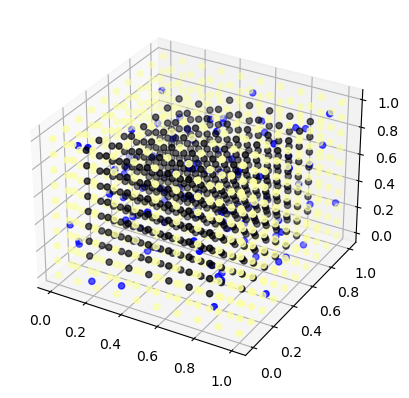

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Generate some random 3D points
points = np.random.rand(100, 3)

# Define the grid coordinates
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
z = np.linspace(0, 1, 10)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Compute the point density on the grid
grid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
densities = griddata(points, np.ones(points.shape[0]), grid_points, method="linear", fill_value=0)

densities = (densities/np.sum(densities)) * np.sum(points)

# Plot the point density on the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b')
ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], c=densities, cmap="inferno_r")
plt.show()

